In [275]:
# Update House Prices
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [347]:
# load data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

print('Train:{}   Test:{}'.format(train.shape,test.shape))

Train:(1460, 81)   Test:(1459, 80)


In [348]:
train, y = train.loc[:, train.columns != 'SalePrice'], train['SalePrice']

In [349]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [350]:
missing = train.isnull().sum()
missing

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

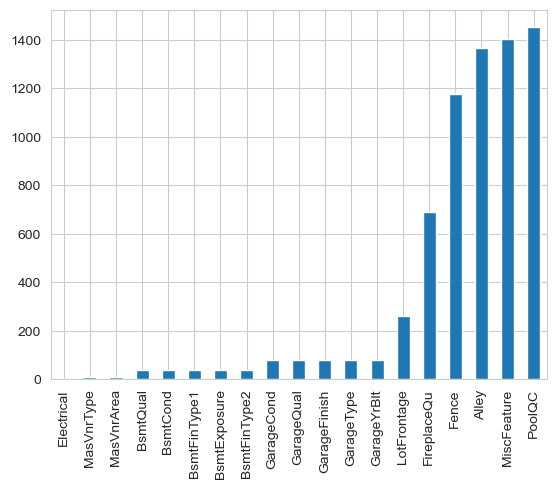

In [351]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.show()

In [354]:
from sklearn.impute import KNNImputer

def preprocessing_missing(df):
    df = df.drop(['Id', 'LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'], axis=1)

    #numeric
    num_cols = df.select_dtypes(exclude = 'object').columns
    for col in num_cols:
        imputer = KNNImputer(n_neighbors=3)
        df[col] = imputer.fit_transform(df[[col]])
    

    # #categorical
    cat_cols = df.select_dtypes(include = 'object').columns
    for col in cat_cols:
        fill = df[col].mode()[0]
        df[col].fillna(fill, inplace=True)
    
    return df[num_cols]


In [355]:
train = preprocessing_missing(train)
test = preprocessing_missing(test)

In [359]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def preprocessing_num(df):
    #numeric
    num_cols = df.select_dtypes(include = 'number').columns
    for col in num_cols:
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
    
    return df


In [360]:
train = preprocessing_num(train)
test = preprocessing_num(test)

In [361]:
from sklearn.preprocessing import LabelEncoder

def preprocessing_cat(df):
    #categorical
    cat_cols = df.select_dtypes(include = 'object').columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    return df

In [362]:
train = preprocessing_cat(train)
test = preprocessing_cat(test)

In [363]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test=train_test_split(train, y, random_state=1225)


# kfolds = KFold(n_splits=10, shuffle=True, random_state= 1225)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X = train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [364]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

randomforest = RandomForestRegressor(n_estimators=200,
                                        max_depth=15, 
                                        criterion = 'squared_error')


lightgbm = LGBMRegressor(objective='regression', 
                            num_leaves=4,
                            learning_rate=0.01, 
                            n_estimators=5000,
                            max_bin=200, 
                            bagging_fraction=0.75,
                            bagging_freq=5, 
                            bagging_seed=7,
                            feature_fraction=0.2,
                            feature_fraction_seed=7,
                            verbose=-1,
                            )

xgboost = XGBRegressor(learning_rate=0.01,
                        n_estimators=3460,
                        max_depth=3, min_child_weight=0,
                        gamma=0, subsample=0.7,
                        colsample_bytree=0.7,
                        objective='reg:linear', nthread=-1,
                        scale_pos_weight=1, seed=27,
                        reg_alpha=0.00006)                               

In [368]:
estimators = [randomforest, lightgbm, xgboost]

randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
print(f'RMSE of randomforest: {rmse(y_test, y_pred)}')

lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print(f'RMSE of lightgbm: {rmse(y_test, y_pred)}')

xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print(f'RMSE of xgboost: {rmse(y_test, y_pred)}')


RMSE of randomforest: 25003.411071737064
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
RMSE of lightgbm: 26817.158127851602
[20:16:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


/Users/chai/opt/anaconda3/envs/chaienv/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE of xgboost: 22908.060344538135


In [384]:
submission.iloc[:,1] = randomforest.predict(test)

In [387]:
submission.to_csv('../result/randomforest/1.csv', index=False)